# Premier League Players Analysis (2018–2023)

## 1️⃣ Data Preparation
- **Loaded the dataset** `Players.xlsx` from `"D:\DEPI Final project\Players.xlsx"`.
- Dataset columns: `Player, Nation, Pos, Squad, Matches_Played, Starts, Min, 90s, Goals, Assists, G+A, Non_Penalty_Goals, Penalty_Goals, Penalty_Attempts, Yellow_Cards, Red_Cards, Expected_Goals, Non_Penalty_xG, Expected_Assists, npxG+xAG, Progressive_Carries, Progressive_Passes, Date`.
- Converted `Date` column to datetime and extracted **Year**.
- Calculated derived metrics:
  - `goals_per90 = Goals / (Min/90)`
  - `delta_goals` = Goals difference season vs previous season

## 2️⃣ Top Players Selection
- Aggregated total goals per player across 2018–2023.
- Selected **Top 10 scorers** for detailed analysis.

## 3️⃣ Performance Aggregation
- For Top10 players, aggregated:
  - `total_goals`, `total_minutes`, `avg_goals_per90`
  - `Non_Penalty_xG`, `Progressive_Passes`, `Progressive_Carries`
- Calculated additional metrics:
  - `efficiency = total_goals / Non_Penalty_xG`
  - `avg_minutes_per_season`
  - `consistency = coefficient of variation (CV) of goals_per90`

## 4️⃣ Visualization / Business-Oriented Charts
1. **ROI Scatter:** Total Goals vs Total Minutes (marker size = minutes, color = player)  
   _Helps to identify best value players for investment._
2. **Recent Δ Goals:** Horizontal bar chart for last season  
   _Highlights breakout vs decline players._
3. **Consistency Ranking:** Bar chart of CV (goals_per90)  
   _Shows most stable performers._
4. **Transfer Priority Score:** Composite score (goals_per90 × consistency × availability × efficiency)  
   _Guides transfer / signing decisions._
5. **Radar Charts:** Normalized metrics per player (Top10)  
   _Quick comparison of strengths: scoring, efficiency, progressive passes & carries._


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from IPython.display import display, HTML

try:
    from caas_jupyter_tools import display_dataframe_to_user
    have_caas = True
except Exception:
    have_caas = False

pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
plt.rcParams["figure.figsize"] = (10,5)

In [2]:
path = r"D:\DEPI Final project\Players.xlsx"
print("Loading:", path)
df = pd.read_excel(path)
print("Loaded rows:", len(df))
print("Columns:", list(df.columns))
display(df.head(3))

Loading: D:\DEPI Final project\Players.xlsx
Loaded rows: 3257
Columns: ['Player', 'Nation', 'Pos', 'Squad', 'Matches_Played', 'Starts', 'Min', '90s', 'Goals', 'Assists', 'G+A', 'Non_Penalty_Goals', 'Penalty_Goals', 'Penalty_Attempts', 'Yellow_Cards', 'Red_Cards', 'Expected_Goals', 'Non_Penalty_xG', 'Expected_Assists', 'npxG+xAG', 'Progressive_Carries', 'Progressive_Passes', 'Date']


,Player,Nation,Pos,Squad,Matches_Played,Starts,Min,90s,Goals,Assists,G+A,Non_Penalty_Goals,Penalty_Goals,Penalty_Attempts,Yellow_Cards,Red_Cards,Expected_Goals,Non_Penalty_xG,Expected_Assists,npxG+xAG,Progressive_Carries,Progressive_Passes,Date
0,Luke Amos,ENG,Midfielder,Tottenham,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Monday, January 1, 2018"
1,Antonio Barreca,ITA,Defensive Midfielder,Newcastle Utd,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Monday, January 1, 2018"
2,Rafael Camacho,POR,Defensive Midfielder,Liverpool,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Monday, January 1, 2018"


In [3]:
# تنظيف بسيط و parse للتاريخ
df.columns = [c.strip() for c in df.columns]   # تظبيط أسماء الأعمدة
if 'Date' not in df.columns:
    raise RuntimeError("Expected a 'Date' column but it was not found. Columns: " + ", ".join(df.columns))

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
n_bad_dates = df['Date'].isna().sum()
if n_bad_dates>0:
    print(f"Warning: {n_bad_dates} rows have unparsable Date and will be dropped for season grouping.")
    df = df.dropna(subset=['Date'])

df['Year'] = df['Date'].dt.year
df = df[df['Year'].between(2018, 2023)].copy()
print("After filtering 2018-2023 rows:", len(df))
display(df.head(3))

After filtering 2018-2023 rows: 3257


,Player,Nation,Pos,Squad,Matches_Played,Starts,Min,90s,Goals,Assists,G+A,Non_Penalty_Goals,Penalty_Goals,Penalty_Attempts,Yellow_Cards,Red_Cards,Expected_Goals,Non_Penalty_xG,Expected_Assists,npxG+xAG,Progressive_Carries,Progressive_Passes,Date,Year
0,Luke Amos,ENG,Midfielder,Tottenham,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018-01-01,2018
1,Antonio Barreca,ITA,Defensive Midfielder,Newcastle Utd,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018-01-01,2018
2,Rafael Camacho,POR,Defensive Midfielder,Liverpool,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018-01-01,2018


In [5]:
# نتأكد من الأعمدة الرقمية ونعالج القيم المفقودة
numeric_cols = ['Matches_Played','Starts','Min','90s','Goals','Assists','G+A',
                'Non_Penalty_Goals','Penalty_Goals','Penalty_Attempts',
                'Yellow_Cards','Red_Cards','Expected_Goals','Non_Penalty_xG',
                'Expected_Assists','npxG+xAG','Progressive_Carries','Progressive_Passes']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    else:
        df[col] = 0 

display(df[numeric_cols + ['Player','Year']].head(3))

,Matches_Played,Starts,Min,90s,Goals,Assists,G+A,Non_Penalty_Goals,Penalty_Goals,Penalty_Attempts,Yellow_Cards,Red_Cards,Expected_Goals,Non_Penalty_xG,Expected_Assists,npxG+xAG,Progressive_Carries,Progressive_Passes,Player,Year
0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Luke Amos,2018
1,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Antonio Barreca,2018
2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rafael Camacho,2018


In [6]:
# تجميع لكل لاعب لكل سنة (season)
agg_cols = numeric_cols
player_year = (
    df
    .groupby(['Player','Year'], as_index=False)[agg_cols]
    .sum()
)
# حساب goals_per90 و minutes_per_season
player_year['goals_per90'] = np.where(player_year['Min']>0, player_year['Goals']*90/player_year['Min'], 0)
player_year['minutes_per_season'] = player_year['Min']
player_year = player_year.sort_values(['Player','Year']).reset_index(drop=True)

print("Aggregated player x year shape:", player_year.shape)
display(player_year.head(8))

Aggregated player x year shape: (3205, 22)


,Player,Year,Matches_Played,Starts,Min,90s,Goals,Assists,G+A,Non_Penalty_Goals,Penalty_Goals,Penalty_Attempts,Yellow_Cards,Red_Cards,Expected_Goals,Non_Penalty_xG,Expected_Assists,npxG+xAG,Progressive_Carries,Progressive_Passes,goals_per90,minutes_per_season
0,Aaron Connolly,2019,24,14,1258,14,3,1,4,3,0,0,0,0,4,4,0,4,21,10,0.214626,1258
1,Aaron Connolly,2020,17,9,791,9,2,1,3,2,0,0,0,0,4,4,0,4,12,4,0.227560,791
2,Aaron Connolly,2021,4,1,156,2,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0.000000,156
3,Aaron Cresswell,2018,20,18,1589,18,0,1,1,0,0,0,1,0,0,0,1,2,35,94,0.000000,1589
4,Aaron Cresswell,2019,31,31,2727,30,3,0,3,3,0,0,7,0,1,1,3,4,43,166,0.099010,2727
5,Aaron Cresswell,2020,36,36,3170,35,0,8,8,0,0,0,3,0,1,1,6,8,35,162,0.000000,3170
6,Aaron Cresswell,2021,31,31,2726,30,2,3,5,2,0,0,3,0,1,1,3,4,54,186,0.066031,2726
7,Aaron Cresswell,2022,28,24,2235,25,0,1,1,0,0,0,3,0,0,0,4,4,35,145,0.000000,2235


In [7]:
# حساب الفرق delta goals بالمقارنة بالموسم السابق لكل لاعب
player_year['prev_goals'] = player_year.groupby('Player')['Goals'].shift(1).fillna(0)
player_year['delta_goals'] = player_year['Goals'] - player_year['prev_goals']
player_year['pct_change_goals'] = np.where(player_year['prev_goals']>0,
                                          player_year['delta_goals'] / player_year['prev_goals'],
                                          np.nan)
display(player_year.head(12))

,Player,Year,Matches_Played,Starts,Min,90s,Goals,Assists,G+A,Non_Penalty_Goals,Penalty_Goals,Penalty_Attempts,Yellow_Cards,Red_Cards,Expected_Goals,Non_Penalty_xG,Expected_Assists,npxG+xAG,Progressive_Carries,Progressive_Passes,goals_per90,minutes_per_season,prev_goals,delta_goals,pct_change_goals
0,Aaron Connolly,2019,24,14,1258,14,3,1,4,3,0,0,0,0,4,4,0,4,21,10,0.214626,1258,0.0,3.0,NaN
1,Aaron Connolly,2020,17,9,791,9,2,1,3,2,0,0,0,0,4,4,0,4,12,4,0.227560,791,3.0,-1.0,-0.333333
2,Aaron Connolly,2021,4,1,156,2,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0.000000,156,2.0,-2.0,-1.000000
3,Aaron Cresswell,2018,20,18,1589,18,0,1,1,0,0,0,1,0,0,0,1,2,35,94,0.000000,1589,0.0,0.0,NaN
4,Aaron Cresswell,2019,31,31,2727,30,3,0,3,3,0,0,7,0,1,1,3,4,43,166,0.099010,2727,0.0,3.0,NaN
5,Aaron Cresswell,2020,36,36,3170,35,0,8,8,0,0,0,3,0,1,1,6,8,35,162,0.000000,3170,3.0,-3.0,-1.000000
6,Aaron Cresswell,2021,31,31,2726,30,2,3,5,2,0,0,3,0,1,1,3,4,54,186,0.066031,2726,0.0,2.0,NaN
7,Aaron Cresswell,2022,28,24,2235,25,0,1,1,0,0,0,3,0,0,0,4,4,35,145,0.000000,2235,2.0,-2.0,-1.000000
8,Aaron Cresswell,2023,11,4,436,5,0,0,0,0,0,0,1,0,0,0,0,0,4,26,0.000000,436,0.0,0.0,NaN
9,Aaron Hickey,2022,26,23,1916,21,0,1,1,0,0,0,7,0,0,0,0,1,41,81,0.000000,1916,0.0,0.0,NaN


In [10]:
# اختيار top 30 scorers عبر 2018-2023 (حسب مجموع الأهداف في الفترة)
totals = player_year.groupby('Player', as_index=False)['Goals'].sum().rename(columns={'Goals':'total_goals_2018_2023'})
top30_players = totals.sort_values('total_goals_2018_2023', ascending=False).head(30)['Player'].tolist()
print("Top 30 players count:", len(top30_players))
display(totals.sort_values('total_goals_2018_2023', ascending=False).head(30))

Top 30 players count: 30


,Player,total_goals_2018_2023
916,Mohamed Salah,123
469,Harry Kane,105
1173,Son Heung-min,90
562,Jamie Vardy,74
1050,Raheem Sterling,74
184,Callum Wilson,69
1117,Sadio Mané,67
833,Marcus Rashford,66
375,Erling Haaland,63
991,Ollie Watkins,59


In [11]:
# جدول المطلوب للـ selected players مثلاً top30: goals_per_season, minutes_per_season, ΔPlayerGoals
selected = player_year[player_year['Player'].isin(top30_players)].copy()
selected_table = selected[['Player','Year','Goals','minutes_per_season','delta_goals','goals_per90','prev_goals','pct_change_goals']].sort_values(['Player','Year'])
selected_table = selected_table.rename(columns={
    'Goals':'goals_per_season',
    'minutes_per_season':'minutes_per_season',
    'delta_goals':'delta_goals_vs_prev'
})

if have_caas:
    display_dataframe_to_user("Top30_players_goals_minutes_delta", selected_table)
else:
    display(selected_table)

,Player,Year,goals_per_season,minutes_per_season,delta_goals_vs_prev,goals_per90,prev_goals,pct_change_goals
431,Bruno Fernandes,2019,8,1186,8.0,0.607083,0.0,NaN
432,Bruno Fernandes,2020,18,3099,10.0,0.522749,8.0,1.250000
433,Bruno Fernandes,2021,10,3111,-8.0,0.289296,18.0,-0.444444
434,Bruno Fernandes,2022,8,3316,-2.0,0.217129,10.0,-0.200000
435,Bruno Fernandes,2023,10,3118,2.0,0.288647,8.0,0.250000
446,Bukayo Saka,2018,0,8,0.0,0.000000,0.0,NaN
447,Bukayo Saka,2019,1,1753,1.0,0.051341,0.0,NaN
448,Bukayo Saka,2020,5,2553,4.0,0.176263,1.0,4.000000
449,Bukayo Saka,2021,11,2978,6.0,0.332438,5.0,1.200000
450,Bukayo Saka,2022,14,3181,3.0,0.396102,11.0,0.272727


In [12]:
# تصنيف breakout / decline
def classify_delta(row):
    prev = row['prev_goals']
    delta = row['delta_goals']
    threshold = max(3, 0.5*prev)
    if prev==0:
        if row['Goals'] >= 3:
            return 'breakout'
        else:
            return 'stable' if delta==0 else ('decline' if delta<0 else 'improving')
    if delta >= threshold:
        return 'breakout'
    if delta <= -threshold:
        return 'decline'
    if delta > 0:
        return 'improving'
    if delta < 0:
        return 'declining'
    return 'stable'

selected['status'] = selected.apply(classify_delta, axis=1)
selected_table = selected_table.merge(selected[['Player','Year','status']], on=['Player','Year'], how='left')
display(selected_table)

,Player,Year,goals_per_season,minutes_per_season,delta_goals_vs_prev,goals_per90,prev_goals,pct_change_goals,status
0,Bruno Fernandes,2019,8,1186,8.0,0.607083,0.0,NaN,breakout
1,Bruno Fernandes,2020,18,3099,10.0,0.522749,8.0,1.250000,breakout
2,Bruno Fernandes,2021,10,3111,-8.0,0.289296,18.0,-0.444444,declining
3,Bruno Fernandes,2022,8,3316,-2.0,0.217129,10.0,-0.200000,declining
4,Bruno Fernandes,2023,10,3118,2.0,0.288647,8.0,0.250000,improving
5,Bukayo Saka,2018,0,8,0.0,0.000000,0.0,NaN,stable
6,Bukayo Saka,2019,1,1753,1.0,0.051341,0.0,NaN,improving
7,Bukayo Saka,2020,5,2553,4.0,0.176263,1.0,4.000000,breakout
8,Bukayo Saka,2021,11,2978,6.0,0.332438,5.0,1.200000,breakout
9,Bukayo Saka,2022,14,3181,3.0,0.396102,11.0,0.272727,improving


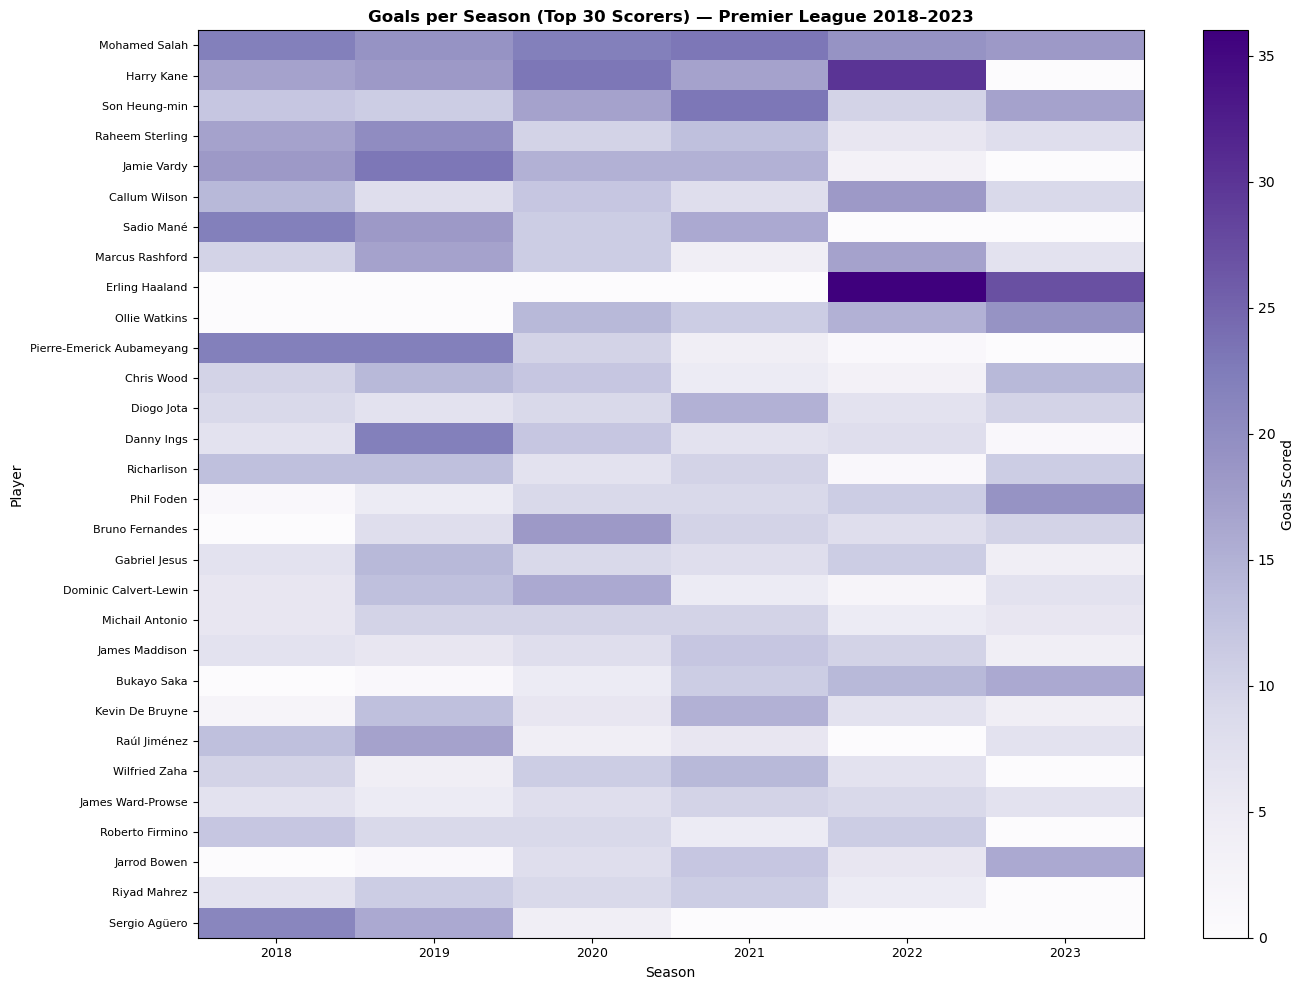

In [14]:
# heatmap goals per season (purple gradients) للـ top30
pivot_goals = selected.pivot_table(
    index='Player',
    columns='Year',
    values='Goals',
    aggfunc='sum',
    fill_value=0
)

# ترتيب اللاعبين حسب مجموع الأهداف في الفترة
player_order = totals[totals['Player'].isin(pivot_goals.index)] \
                .sort_values('total_goals_2018_2023', ascending=False)['Player']

pivot_goals = pivot_goals.loc[player_order]

fig, ax = plt.subplots(figsize=(14, 10))

# ✅ استخدام الطريقة الحديثة للـ colormap
cmap = plt.colormaps.get_cmap('Purples')

# Normalization based on data
norm = Normalize(vmin=0, vmax=max(1, pivot_goals.values.max()))

# رسم الهيتماب
im = ax.imshow(pivot_goals.values, aspect='auto', cmap=cmap, norm=norm)

# إعداد اللابلز
ax.set_yticks(np.arange(len(pivot_goals.index)))
ax.set_yticklabels(pivot_goals.index, fontsize=8)  # خط أصغر ليتناسب مع العدد

ax.set_xticks(np.arange(len(pivot_goals.columns)))
ax.set_xticklabels(pivot_goals.columns, fontsize=9)

ax.set_xlabel("Season")
ax.set_ylabel("Player")

ax.set_title("Goals per Season (Top 30 Scorers) — Premier League 2018–2023",
             fontsize=12, fontweight='bold')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Goals Scored")

plt.tight_layout()
plt.show()

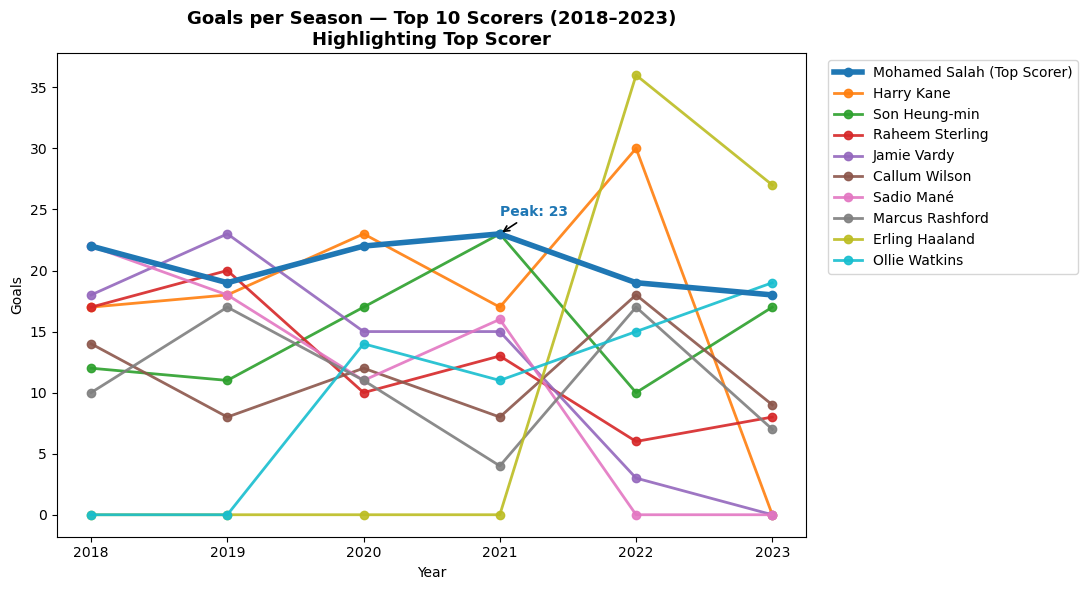

In [23]:
# احسن هدافين على مدار المواسم

top10_sorted = pivot_goals.sum(axis=1).sort_values(ascending=False).head(10)
top10_players = top10_sorted.index.tolist()

fig, ax = plt.subplots(figsize=(11, 6))
years = sorted(pivot_goals.columns.tolist())

cmap = plt.colormaps.get_cmap('tab10')
colors = [cmap(i % 10) for i in range(len(top10_players))]

best_player = top10_players[0]

for i, player in enumerate(top10_players):
    vals = pivot_goals.loc[player].reindex(years).values
    
    if player == best_player:
        ax.plot(
            years, vals,
            label=f"{player} (Top Scorer)",
            linewidth=4, marker='o',
            color=colors[i],
            zorder=3
        )

        peak_index = np.argmax(vals)
        peak_year = years[peak_index]
        peak_val = vals[peak_index]

        ax.annotate(
            f"Peak: {peak_val}",
            xy=(peak_year, peak_val),
            xytext=(peak_year, peak_val + 1.5),
            arrowprops=dict(arrowstyle="->", linewidth=1.2),
            fontsize=10, fontweight='bold', color=colors[i]
        )
    else:
        ax.plot(
            years, vals,
            label=player,
            linewidth=2, marker='o',
            color=colors[i],
            alpha=0.9
        )

ax.set_xlabel("Year")
ax.set_ylabel("Goals")
ax.set_title(
    "Goals per Season — Top 10 Scorers (2018–2023)\nHighlighting Top Scorer",
    fontsize=13, fontweight='bold'
)

ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

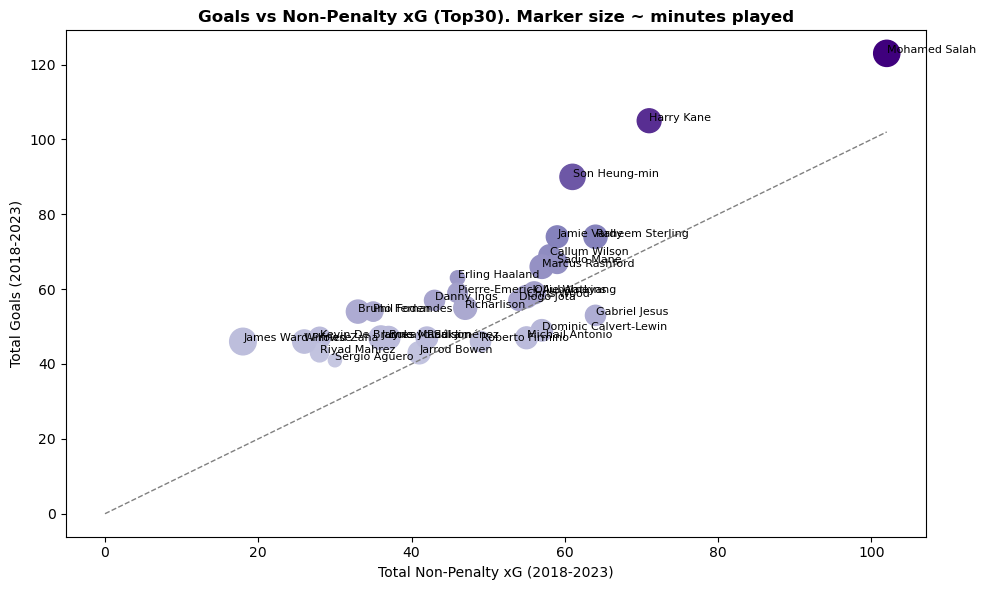

In [24]:
# Efficiency chart: Goals vs Non_Penalty_xG for Top30
# aggregate totals across seasons 2018-2023 (نستخدم البيانات اللي عندنا)
top30_df = player_year[player_year['Player'].isin(top30_players)].copy()
agg_top30 = top30_df.groupby('Player', as_index=False).agg(
    total_goals = ('Goals','sum'),
    total_npxG = ('Non_Penalty_xG','sum'),
    total_minutes = ('Min','sum'),
    avg_goals_per90 = ('goals_per90','mean')
)
# scatter plot
fig, ax = plt.subplots(figsize=(10,6))
cmap = plt.colormaps.get_cmap('Purples')
sc = ax.scatter(agg_top30['total_npxG'], agg_top30['total_goals'],
                s = np.clip(agg_top30['total_minutes'] / 50, 20, 500),
                cmap=cmap, c=agg_top30['total_goals'], norm=Normalize(vmin=0, vmax=agg_top30['total_goals'].max()))
for _, r in agg_top30.iterrows():
    ax.text(r['total_npxG'] + 0.02, r['total_goals'] + 0.02, r['Player'], fontsize=8)
ax.plot([0, max(agg_top30['total_npxG'].max(), 1)], [0, max(agg_top30['total_npxG'].max(), 1)], linestyle='--', linewidth=1, color='grey')
ax.set_xlabel("Total Non-Penalty xG (2018-2023)")
ax.set_ylabel("Total Goals (2018-2023)")
ax.set_title("Goals vs Non-Penalty xG (Top30). Marker size ~ minutes played", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Premier League Top10 Players Analysis (2018–2023)  
**Focus:** Business Insights for Club Management

---

## 1️⃣ Top10 Players Selection
- Aggregated **total goals** per player from 2018 to 2023.
- Selected **Top10 scorers** for detailed business-oriented analysis.

---

## 2️⃣ Charts & Insights

### 2.1 ROI Scatter: Goals vs Total Minutes
- **What it shows:** Player scoring output relative to playing time.  
- **Business insight:**  
  - Players with **high goals but fewer minutes** = high-value, cost-effective investments.  
  - Players with **many minutes but low goals** = possible resource inefficiency.  
- **Visualization:** Scatter plot with marker size proportional to minutes and distinct color per player.

---

### 2.2 Recent Δ Goals: Season-to-Season Change
- **What it shows:** Improvement or decline in last season’s goals compared to previous season.  
- **Business insight:**  
  - Positive Δ = breakout candidate, possible target for signing or contract extension.  
  - Negative Δ = decline, potential candidate for transfer or careful monitoring.  
- **Visualization:** Horizontal bar chart (green = improvement, red = decline).

---

### 2.3 Consistency Ranking: Coefficient of Variation (Goals per 90)
- **What it shows:** Variability in player scoring per 90 minutes across seasons.  
- **Business insight:**  
  - Low CV = consistent performers → reliable for long-term planning.  
  - High CV = fluctuating performers → higher risk, monitor before contract decisions.  
- **Visualization:** Bar chart with purple gradient palette.

---

### 2.4 Transfer Priority Score
- **What it shows:** Composite score of Top10 players combining:  
  - Scoring rate (`avg_goals_per90`)  
  - Consistency (`1 / CV`)  
  - Availability (`avg_minutes_season`)  
  - Efficiency (`goals / Non_Penalty_xG`)  
- **Business insight:**  
  - High score = top priority for signing or retaining.  
  - Low score = monitor or consider for transfer.  
- **Visualization:** Bar chart with purple gradient showing priority ranking.

---

### 2.5 Radar Charts: Multi-Metric Player Comparison
- **Metrics included:**  
  - Goals per 90  
  - Avg minutes per season  
  - Efficiency (Goals / Non_Penalty_xG)  
  - Progressive passes  
  - Progressive carries  
- **Business insight:**  
  - Provides a **quick visual comparison** of Top10 players’ strengths and weaknesses.  
  - Helps identify specialist roles, training focus, and transfer targets.  
- **Visualization:** Normalized radar charts (one per player, color-coded).

---

## 3️⃣ Next Steps for Management
- Use **ROI and Δ Goals** to identify breakout stars and declining assets.  
- Use **Consistency** to decide reliable players for contracts.  
- Use **Transfer Priority Score** as a shortlist for investment decisions.  
- Use **Radar Charts** to balance squad composition and plan tactical roles. 


In [28]:
# Cell A - تجهيز Top10 و Aggregations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.patches import Patch
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
import seaborn as sns

# تأكد من وجود player_year و totals من التحضير السابق؛ لو مش موجودين أعد تجميع player_year
# هنا باختصار نحدد top10 بناءً على مجموع الأهداف عبر 2018-2023
totals = player_year.groupby('Player', as_index=False)['Goals'].sum().rename(columns={'Goals':'total_goals_2018_2023'})
totals = totals.sort_values('total_goals_2018_2023', ascending=False).reset_index(drop=True)
top10_players = totals.head(10)['Player'].tolist()
print("Top10 players selected:", top10_players)

# تجميع إحصاءات إجمالية للـ Top10
agg_top10 = player_year[player_year['Player'].isin(top10_players)].groupby('Player').agg(
    total_goals = ('Goals','sum'),
    total_minutes = ('Min','sum'),
    seasons_played = ('Year','nunique'),
    avg_goals_per90 = ('goals_per90','mean'),
    total_npxG = ('Non_Penalty_xG','sum'),
    prog_passes = ('Progressive_Passes','sum'),
    prog_carries = ('Progressive_Carries','sum')
).reset_index()

# efficiency: goals / npxG (حساب مع حماية من القسمة على صفر)
agg_top10['efficiency'] = np.where(agg_top10['total_npxG']>0, agg_top10['total_goals'] / agg_top10['total_npxG'], np.nan)
# availability: avg minutes per season proxy
agg_top10['avg_minutes_season'] = np.where(agg_top10['seasons_played']>0, agg_top10['total_minutes'] / agg_top10['seasons_played'], 0)

# consistency: compute CV of goals_per90 per player
cv_df = player_year[player_year['Player'].isin(top10_players)].groupby('Player').agg(
    mean_g90 = ('goals_per90','mean'),
    std_g90 = ('goals_per90','std')
).reset_index()
cv_df['cv_g90'] = np.where(cv_df['mean_g90']>0, cv_df['std_g90'] / cv_df['mean_g90'], np.inf)
agg_top10 = agg_top10.merge(cv_df[['Player','cv_g90']], on='Player', how='left')

# ترتيب للعرض
agg_top10 = agg_top10.sort_values('total_goals', ascending=False).reset_index(drop=True)
agg_top10

Top10 players selected: ['Mohamed Salah', 'Harry Kane', 'Son Heung-min', 'Jamie Vardy', 'Raheem Sterling', 'Callum Wilson', 'Sadio Mané', 'Marcus Rashford', 'Erling Haaland', 'Ollie Watkins']


,Player,total_goals,total_minutes,seasons_played,avg_goals_per90,total_npxG,prog_passes,prog_carries,efficiency,avg_minutes_season,cv_g90
0,Mohamed Salah,123,17790,6,0.625933,102,772,690,1.205882,2965.000000,0.120137
1,Harry Kane,105,14730,5,0.639076,71,611,327,1.478873,2946.000000,0.179125
2,Son Heung-min,90,16457,6,0.490428,61,547,600,1.475410,2742.833333,0.261059
3,Jamie Vardy,74,12262,5,0.529005,59,156,216,1.254237,2452.400000,0.448928
4,Raheem Sterling,74,13955,6,0.464234,64,456,744,1.156250,2325.833333,0.326822
5,Callum Wilson,69,11774,6,0.577360,58,165,188,1.189655,1962.333333,0.395764
6,Sadio Mané,67,11453,4,0.524088,59,499,527,1.135593,2863.250000,0.241976
7,Marcus Rashford,66,14282,6,0.400646,57,487,543,1.157895,2380.333333,0.315713
8,Erling Haaland,63,5321,2,1.061146,46,84,70,1.369565,2660.500000,0.145202
9,Ollie Watkins,59,12624,4,0.419312,56,209,270,1.053571,3156.000000,0.201685


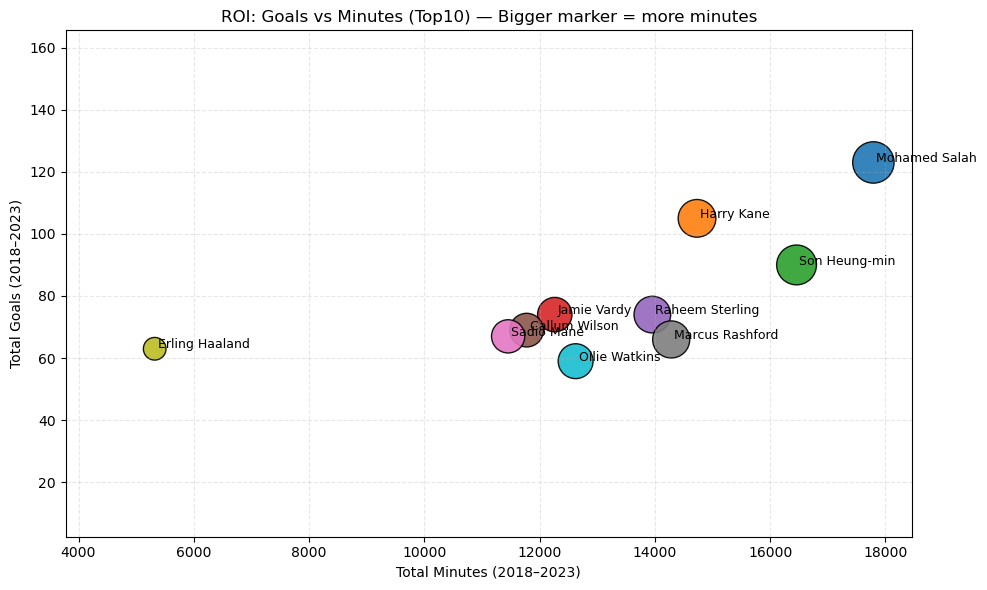

In [29]:
# Cell B - ROI Scatter: Total Goals vs Total Minutes (Top10)
fig, ax = plt.subplots(figsize=(10,6))

# distinct colors per player (tab10)
cmap = plt.colormaps.get_cmap('tab10')
colors = [cmap(i % 10) for i in range(len(agg_top10))]

sc = ax.scatter(
    agg_top10['total_minutes'],
    agg_top10['total_goals'],
    s = np.clip(agg_top10['total_minutes'] / 20, 80, 1200),  # حجم النقطة دليل على minutes
    color = colors,
    alpha = 0.9,
    edgecolor='k'
)

# نصوص اللاعبين
for i, r in agg_top10.iterrows():
    ax.text(r['total_minutes'] + 50, r['total_goals'] + 0.1, r['Player'], fontsize=9)

ax.set_xlabel("Total Minutes (2018–2023)")
ax.set_ylabel("Total Goals (2018–2023)")
ax.set_title("ROI: Goals vs Minutes (Top10) — Bigger marker = more minutes")

# محور ثانوي بسيط: goals per 90 lines (iso-lines)
max_min = max(agg_top10['total_minutes'].max(), 1)
mins_lin = np.linspace(0, max_min, 5)[1:]
for m in mins_lin:
    # iso-line for goals per 90 = g90 => goals = g90 * minutes / 90
    for g90 in [0.2, 0.4, 0.6, 0.8]:
        y = g90 * m / 90
        ax.plot([m], [y], marker='.', color='none')  # placeholder to set scale
# tidy
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


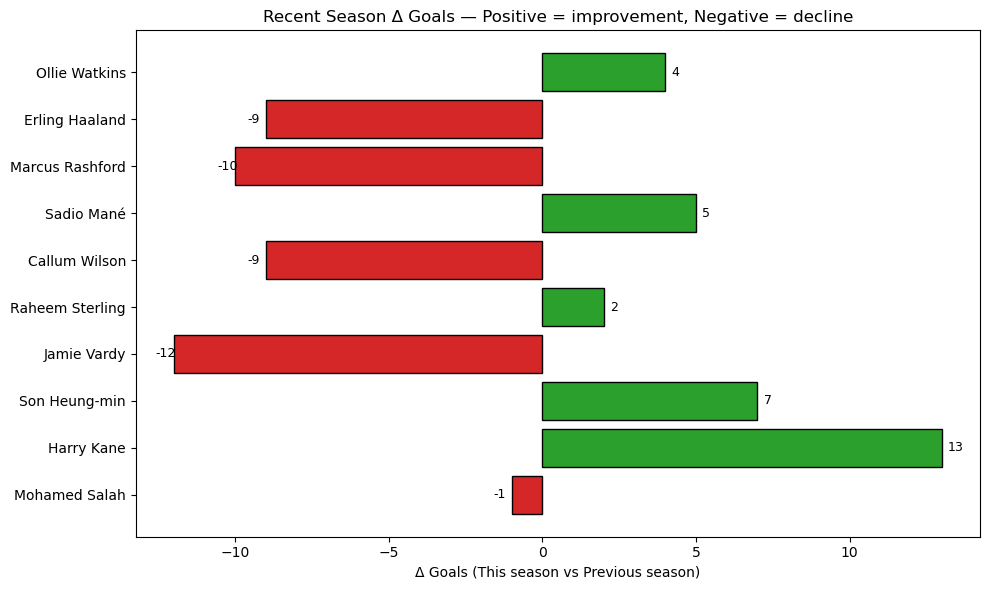

In [30]:
# Cell C - Recent Δ (season vs prev) Bar: آخر موسم موجود لكل لاعب — breakout/decline signal
# نجيب آخر سنة متاحة لكل لاعب (قد تكون 2023 أو أقل إذا غير متوفر)
latest = player_year[player_year['Player'].isin(top10_players)].sort_values(['Player','Year']).groupby('Player').tail(1)
# delta_goals موجود بالفعل في player_year
latest = latest.set_index('Player').loc[top10_players].reset_index()

fig, ax = plt.subplots(figsize=(10,6))
colors_bar = ['tab:green' if x>0 else 'tab:red' if x<0 else 'grey' for x in latest['delta_goals']]
ax.barh(latest['Player'], latest['delta_goals'], color=colors_bar, edgecolor='k')
ax.set_xlabel("Δ Goals (This season vs Previous season)")
ax.set_title("Recent Season Δ Goals — Positive = improvement, Negative = decline")
for i, v in enumerate(latest['delta_goals']):
    ax.text(v + (0.2 if v>=0 else -0.6), i, f"{int(v)}", va='center', fontsize=9, color='black')
plt.tight_layout()
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_5172\1638847006.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cv_g90', y='Player', data=cons, palette='Purples', ax=ax)


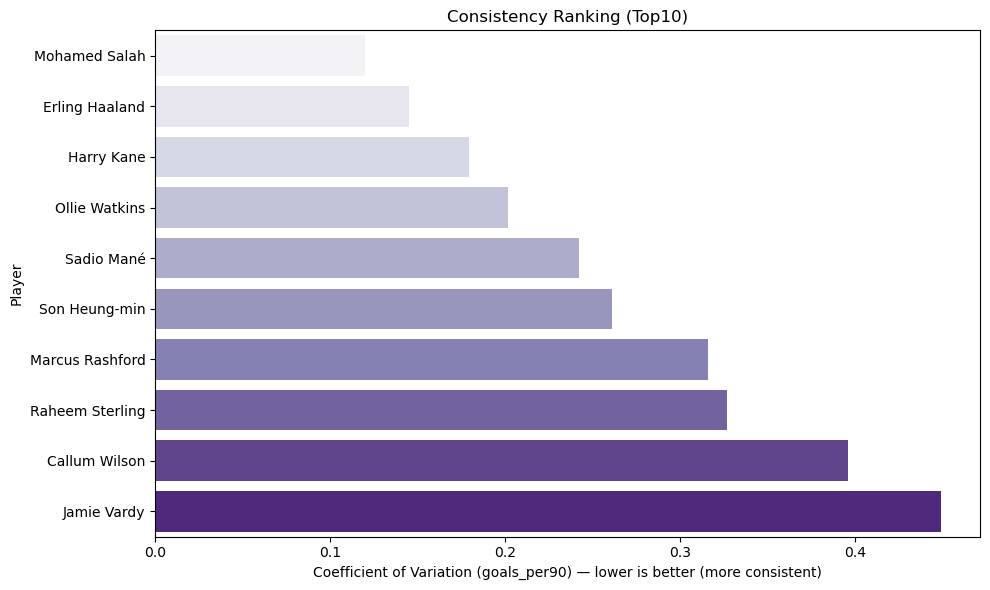

In [31]:
# Cell D - Consistency Bar: CV of goals_per90 (lower = more consistent)
cons = agg_top10.sort_values('cv_g90')
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='cv_g90', y='Player', data=cons, palette='Purples', ax=ax)
ax.set_xlabel("Coefficient of Variation (goals_per90) — lower is better (more consistent)")
ax.set_title("Consistency Ranking (Top10)")
plt.tight_layout()
plt.show()

,Player,total_goals,avg_goals_per90,cv_g90,avg_minutes_season,efficiency,priority_score
0,Erling Haaland,63,1.061,0.145,2660.500,1.370,0.854
1,Harry Kane,105,0.639,0.179,2946.000,1.479,0.654
2,Mohamed Salah,123,0.626,0.120,2965.000,1.206,0.608
3,Son Heung-min,90,0.490,0.261,2742.833,1.475,0.461
4,Sadio Mané,67,0.524,0.242,2863.250,1.136,0.397
5,Ollie Watkins,59,0.419,0.202,3156.000,1.054,0.387
6,Jamie Vardy,74,0.529,0.449,2452.400,1.254,0.231
7,Raheem Sterling,74,0.464,0.327,2325.833,1.156,0.214
8,Marcus Rashford,66,0.401,0.316,2380.333,1.158,0.193
9,Callum Wilson,69,0.577,0.396,1962.333,1.190,0.187


C:\Users\DELL\AppData\Local\Temp\ipykernel_5172\2766342542.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='priority_score', y='Player', data=df_score, palette='Purples', ax=ax)


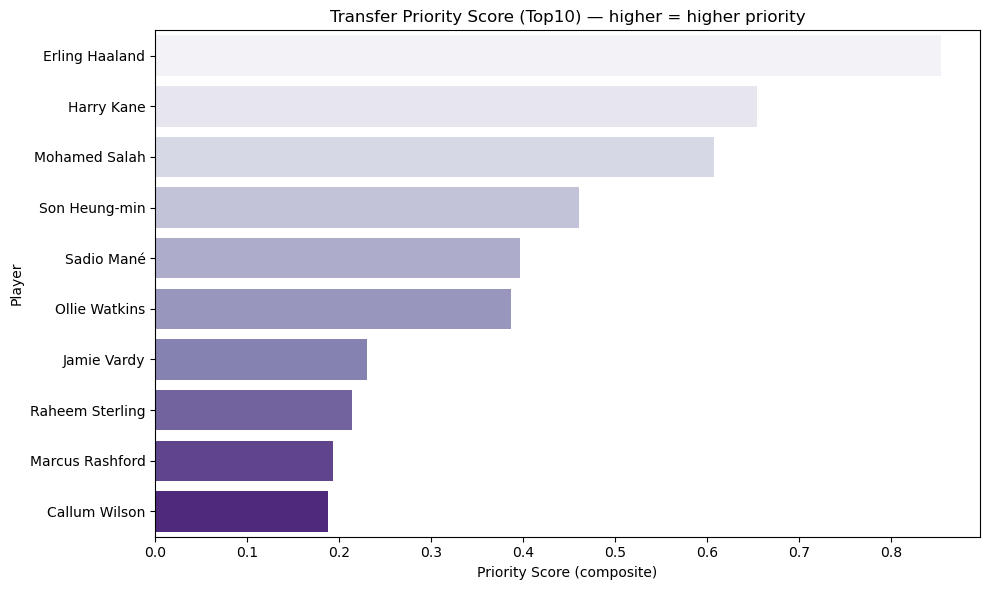

In [32]:
# Cell E - Transfer Priority Score (ترتيب التعاقدات) — حساب Score و عرض جدول + bar
# معايير مبسطة (قابلة للتعديل):
# - offensive impact: avg_goals_per90 (مقياس أساسي)
# - consistency_score: inverse of CV (standardize)
# - availability_score: avg_minutes_season (standardize)
# - efficiency_score: efficiency (goals / npxG) (cap and standardize)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_score = agg_top10.copy()
# replace inf CV with large number then invert
df_score['cv_g90'] = df_score['cv_g90'].replace(np.inf, np.nan).fillna(df_score['cv_g90'].max()*2)
df_score['consistency_score'] = 1 / (1 + df_score['cv_g90'])  # higher = better

# prepare columns for scaling
to_scale = df_score[['avg_goals_per90','consistency_score','avg_minutes_season','efficiency']].fillna(0)
scaled = scaler.fit_transform(to_scale)
df_score[['s_goals90','s_consistency','s_availability','s_efficiency']] = scaled

# weight the components (تعديل الأوزان حسب سياسات النادي)
w = {'goals90':0.4, 'cons':0.25, 'avail':0.2, 'eff':0.15}
df_score['priority_score'] = df_score['s_goals90']*w['goals90'] + df_score['s_consistency']*w['cons'] + df_score['s_availability']*w['avail'] + df_score['s_efficiency']*w['eff']

df_score = df_score.sort_values('priority_score', ascending=False).reset_index(drop=True)

# عرض جدول مختصر + bar
display_cols = ['Player','total_goals','avg_goals_per90','cv_g90','avg_minutes_season','efficiency','priority_score']
display(df_score[display_cols].round(3))

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='priority_score', y='Player', data=df_score, palette='Purples', ax=ax)
ax.set_title("Transfer Priority Score (Top10) — higher = higher priority")
ax.set_xlabel("Priority Score (composite)")
plt.tight_layout()
plt.show()